In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr2k/Flickr2K/001183.png
/kaggle/input/flickr2k/Flickr2K/002594.png
/kaggle/input/flickr2k/Flickr2K/001703.png
/kaggle/input/flickr2k/Flickr2K/002584.png
/kaggle/input/flickr2k/Flickr2K/001840.png
/kaggle/input/flickr2k/Flickr2K/000419.png
/kaggle/input/flickr2k/Flickr2K/000920.png
/kaggle/input/flickr2k/Flickr2K/000585.png
/kaggle/input/flickr2k/Flickr2K/001593.png
/kaggle/input/flickr2k/Flickr2K/002011.png
/kaggle/input/flickr2k/Flickr2K/002312.png
/kaggle/input/flickr2k/Flickr2K/000313.png
/kaggle/input/flickr2k/Flickr2K/002084.png
/kaggle/input/flickr2k/Flickr2K/000603.png
/kaggle/input/flickr2k/Flickr2K/001669.png
/kaggle/input/flickr2k/Flickr2K/000224.png
/kaggle/input/flickr2k/Flickr2K/000121.png
/kaggle/input/flickr2k/Flickr2K/000598.png
/kaggle/input/flickr2k/Flickr2K/001249.png
/kaggle/input/flickr2k/Flickr2K/002604.png
/kaggle/input/flickr2k/Flickr2K/000370.png
/kaggle/input/flickr2k/Flickr2K/002257.png
/kaggle/input/flickr2k/Flickr2K/002454.png
/kaggle/inp

# Loading Data

In [2]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import glob
import os

# Define the dataset class
class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = glob.glob(f"{root_dir}/**/*.png", recursive=True)  # Search recursively
        
        if len(self.image_files) == 0:
            raise ValueError(f"No images found in {root_dir}. Check the dataset path.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert image to tensor
])

# Kaggle dataset paths (Fixed training and validation paths)
flickr2k_path = "/kaggle/input/flickr2k/Flickr2K"
div2k_train_path = "/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR"  # Train Set
div2k_valid_path = "/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR"  # Validation Set

# Create dataset objects
try:
    flickr2k_dataset = SuperResolutionDataset(root_dir=flickr2k_path, transform=transform)
    div2k_train_dataset = SuperResolutionDataset(root_dir=div2k_train_path, transform=transform)
    div2k_valid_dataset = SuperResolutionDataset(root_dir=div2k_valid_path, transform=transform)
except ValueError as e:
    print(e)
    flickr2k_dataset, div2k_train_dataset, div2k_valid_dataset = None, None, None

# Create DataLoaders
if flickr2k_dataset and div2k_train_dataset and div2k_valid_dataset:
    flickr2k_loader = DataLoader(flickr2k_dataset, batch_size=16, shuffle=True)
    div2k_train_loader = DataLoader(div2k_train_dataset, batch_size=16, shuffle=True)
    div2k_valid_loader = DataLoader(div2k_valid_dataset, batch_size=16, shuffle=True)

    # Check dataset loading
    try:
        sample_batch = next(iter(div2k_train_loader))
        print(f"Loaded training batch shape: {sample_batch.shape}")

        sample_batch_valid = next(iter(div2k_valid_loader))
        print(f"Loaded validation batch shape: {sample_batch_valid.shape}")
    except StopIteration:
        print("Error: One of the DataLoaders is empty. Check dataset paths and contents.")


Loaded training batch shape: torch.Size([16, 3, 256, 256])
Loaded validation batch shape: torch.Size([16, 3, 256, 256])


## Sample Images

🔹 Flickr2K Dataset Samples:


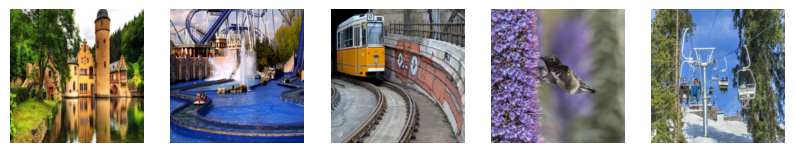

🔹 DIV2K Training Dataset Samples:


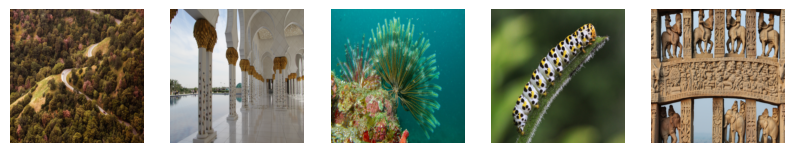

🔹 DIV2K Validation Dataset Samples:


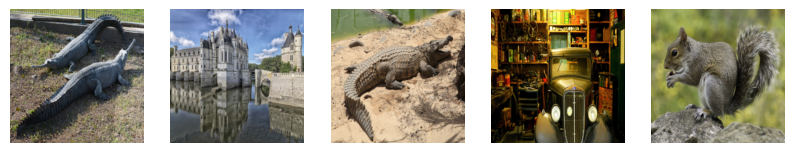

In [3]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display a few images from a DataLoader
def show_images(data_loader, num_images=5):
    batch = next(iter(data_loader))  # Get a batch
    images = batch[:num_images]  # Select first 'num_images' images

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

# Display sample images from each dataset
if flickr2k_loader and div2k_train_loader and div2k_valid_loader:
    print("🔹 Flickr2K Dataset Samples:")
    show_images(flickr2k_loader)

    print("🔹 DIV2K Training Dataset Samples:")
    show_images(div2k_train_loader)

    print("🔹 DIV2K Validation Dataset Samples:")
    show_images(div2k_valid_loader)


# Image preprocessing

> ## generating low resolution images

In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import glob

# Define the dataset class for Super-Resolution
class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, scale_factor=4, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.scale_factor = scale_factor
        self.image_files = glob.glob(f"{root_dir}/*.png")  # Fetch all PNG images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        hr_image = Image.open(img_name).convert("RGB")

        # Create Low-Resolution (LR) version by downscaling
        lr_image = hr_image.resize(
            (hr_image.width // self.scale_factor, hr_image.height // self.scale_factor),
            Image.BICUBIC
        )

        # Apply transformations (resize HR to a fixed size if needed)
        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return lr_image, hr_image  # Return LR-HR pair

# Define transformations (resize HR to a fixed size for consistency)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize HR image to 256x256 (optional)
    transforms.ToTensor(),          # Convert image to tensor
])

# Paths to Kaggle datasets
flickr2k_path = "/kaggle/input/flickr2k/Flickr2K"
div2k_path = "/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR"

# Create dataset objects
flickr2k_dataset = SuperResolutionDataset(root_dir=flickr2k_path, transform=transform)
div2k_dataset = SuperResolutionDataset(root_dir=div2k_path, transform=transform)

# Create DataLoaders
flickr2k_loader = DataLoader(flickr2k_dataset, batch_size=16, shuffle=True)
div2k_loader = DataLoader(div2k_dataset, batch_size=16, shuffle=True)

# Check dataset loading (Display some samples)
lr_batch, hr_batch = next(iter(flickr2k_loader))
print(f"Loaded LR batch shape: {lr_batch.shape}")
print(f"Loaded HR batch shape: {hr_batch.shape}")


Loaded LR batch shape: torch.Size([16, 3, 256, 256])
Loaded HR batch shape: torch.Size([16, 3, 256, 256])


> ## Sample Low resolution Images

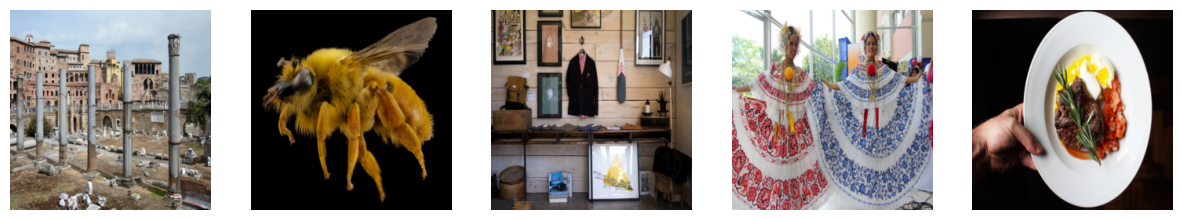

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch

# Function to display a few LR images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        lr_image, hr_image = dataset[i]  # Get LR-HR pair

        # Convert Tensor to PIL Image for visualization
        lr_image = transforms.ToPILImage()(lr_image)

        axes[i].imshow(lr_image)
        axes[i].axis("off")  # Remove axes

    plt.show()

# Display samples from the DIV2K dataset
show_images(div2k_dataset)


# LH-RH Pairing

In [6]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import glob

# Define the dataset class for LR-HR pairing
class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, hr_size=(256, 256), scale_factor=2):
        self.root_dir = root_dir
        self.image_files = glob.glob(f"{root_dir}/*.png")  # Fetch all PNG images
        self.hr_size = hr_size  # Fixed HR size
        self.lr_size = (hr_size[0] // scale_factor, hr_size[1] // scale_factor)  # Calculate LR size

        # Define transformations for HR and LR images
        self.hr_transform = transforms.Compose([
            transforms.Resize(hr_size),  # Resize HR images
            transforms.ToTensor()
        ])
        
        self.lr_transform = transforms.Compose([
            transforms.Resize(self.lr_size),  # Resize LR images
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert("RGB")

        # Generate HR and LR images
        hr_image = self.hr_transform(image)
        lr_image = self.lr_transform(image)

        return lr_image, hr_image  # Return LR-HR pair

# Define dataset paths
flickr2k_path = "/kaggle/input/flickr2k/Flickr2K"
div2k_path = "/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR"

# Create dataset objects with fixed image sizes
flickr2k_dataset = SuperResolutionDataset(root_dir=flickr2k_path, hr_size=(256, 256))
div2k_dataset = SuperResolutionDataset(root_dir=div2k_path, hr_size=(256, 256))

# Create DataLoaders
flickr2k_loader = DataLoader(flickr2k_dataset, batch_size=16, shuffle=True)
div2k_loader = DataLoader(div2k_dataset, batch_size=16, shuffle=True)

# Check dataset loading
sample_lr, sample_hr = next(iter(flickr2k_loader))
print(f"LR batch shape: {sample_lr.shape}, HR batch shape: {sample_hr.shape}")


LR batch shape: torch.Size([16, 3, 128, 128]), HR batch shape: torch.Size([16, 3, 256, 256])


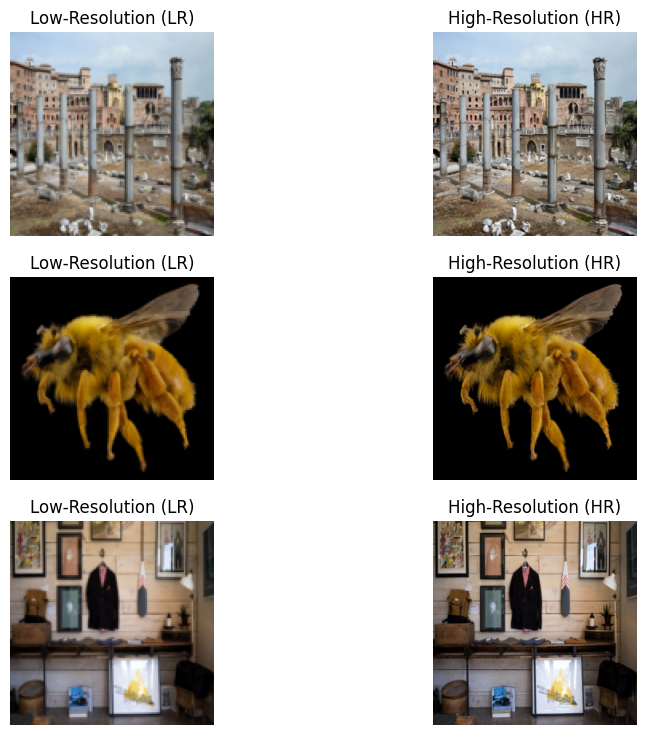

In [7]:
import matplotlib.pyplot as plt

# Function to display LR and HR image pairs
def show_lr_hr(dataset, num_images=3):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

    for i in range(num_images):
        lr_image, hr_image = dataset[i]  # Get LR-HR pair

        # Convert tensors to PIL images for visualization
        lr_image = transforms.ToPILImage()(lr_image)
        hr_image = transforms.ToPILImage()(hr_image)

        axes[i, 0].imshow(lr_image)
        axes[i, 0].set_title("Low-Resolution (LR)")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(hr_image)
        axes[i, 1].set_title("High-Resolution (HR)")
        axes[i, 1].axis("off")

    plt.show()

# Display some LR-HR pairs
show_lr_hr(div2k_dataset)


# Model Architecture

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the SRCNN Model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)  # Feature extraction
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)  # Non-linear mapping
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)  # Reconstruction

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize model, loss function, and optimizer
model = SRCNN()
criterion = nn.MSELoss()  # Mean Squared Error for super-resolution
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [9]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# Training Loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    
    for lr_imgs, hr_imgs in flickr2k_loader:  # Replace with your DataLoader
        # Move data to device (GPU/CPU)
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # 🔹 Upsample LR images to match HR size
        lr_imgs = F.interpolate(lr_imgs, size=(256, 256), mode='bicubic', align_corners=False)

        # Forward pass: Super-resolution output
        sr_imgs = model(lr_imgs)

        # Compute loss (difference between SR output and ground-truth HR)
        loss = criterion(sr_imgs, hr_imgs)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Print loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(flickr2k_loader):.6f}")

print("✅ Training Complete!")


Epoch [1/10], Loss: 0.018010
Epoch [2/10], Loss: 0.002654
Epoch [3/10], Loss: 0.002157
Epoch [4/10], Loss: 0.001973
Epoch [5/10], Loss: 0.001829
Epoch [6/10], Loss: 0.001769
Epoch [7/10], Loss: 0.001702
Epoch [8/10], Loss: 0.001666
Epoch [9/10], Loss: 0.001628
Epoch [10/10], Loss: 0.001592
✅ Training Complete!


In [19]:
import torch

# Save the model
torch.save(model.state_dict(), "super_resolution_model.pth")
print("Model saved successfully!")


Model saved successfully!
